This notebook looks at how many "good" (R/B > 0.6) objects are found per COSMOS field image, and at how a candidate's average R/B score is correlated to the number of times it is detected.

In [2]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dbuser = 'kennedyt' # input("DB User: ")
dbpasswd = 'loq81a5ocd6m' # getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How many "Good" (R/B>0.6) sources are identified per subtraction? (COSMOS)

In [4]:
query = ( 'SELECT subtraction_id, id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb>0.6 '
         'LIMIT 10000000')

cursor.execute( query )

subidobjid_a = np.array( cursor.fetchall() ).transpose()

In [5]:
# Find out how many objects are present in each subtraction (objspersub)
imgs, objspersub = np.unique( subidobjid_a[0], return_counts=True )

Median is 3 objects per subtraction
Mean is 3.351487 objects per subtraction
Max is 164 objects per subtraction
Min is 1 object(s) per subtraction


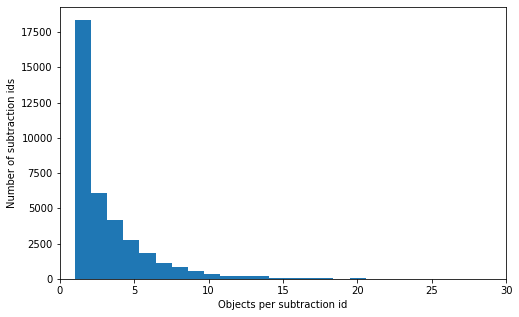

In [6]:
# Throw that data into a histogram
plt.figure( figsize=(8,5) )
plt.ylabel( "Number of subtraction ids" )
plt.xlabel( "Objects per subtraction id" )
plt.hist( objspersub, bins=150 )
plt.xlim( 0, 30 )
print( "Median is %i objects per subtraction" % ( np.median(objspersub) ) )
print( "Mean is %f objects per subtraction" % ( np.mean(objspersub) ) )
print( "Max is %i objects per subtraction" % ( np.max(objspersub) ) )
print( "Min is %i object(s) per subtraction" % ( np.min(objspersub) ) )

#### How many images have been processed so far? (COSMOS)

In [7]:
query = ( 'SELECT exposure_id FROM subtractions s '
         'WHERE q3c_radial_query(s.ra,s.dec,150,2.2,3) ' 
         'LIMIT 10000000' )

cursor.execute( query )

totsub = cursor.fetchall()

In [8]:
len( np.unique( totsub ) )

759

#### How many exposures have been taken? (COSMOS)

In [9]:
query = ( 'SELECT COUNT(*) FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000' )

cursor.execute( query )

totexp = cursor.fetchall()[0][0]

In [10]:
totexp

1122

#### How many "Good" (R/B>0.6) sources are identified per exposure? (COSMOS)

In [11]:
query = ( 'SELECT o.subtraction_id, o.id, s.exposure_id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

subidobjidexpid_a = np.array( cursor.fetchall() )

In [12]:
# Count frequencies of exposure IDs to find out how many objects come from each exposure
exp, objsperimg = np.unique( subidobjidexpid_a.transpose()[2], return_counts=True )

Median is 143 objects per exposure
Mean is 163.052701 objects per exposure
Max is 756 objects per exposure
Min is 12 object(s) per exposure


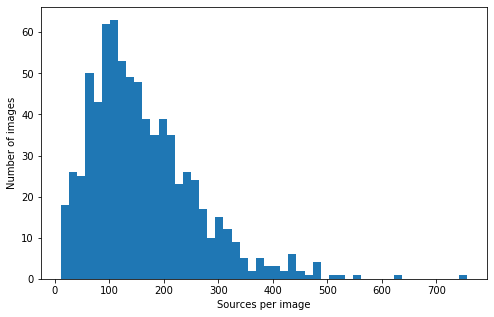

In [13]:
# Plotting
plt.figure( figsize=(8,5) )
plt.hist( objsperimg, bins=50 )
plt.xlabel( "Sources per image" )
plt.ylabel( "Number of images" );
print( "Median is %i objects per exposure" % ( np.median(objsperimg) ) )
print( "Mean is %f objects per exposure" % ( np.mean(objsperimg) ) )
print( "Max is %i objects per exposure" % ( np.max(objsperimg) ) )
print( "Min is %i object(s) per exposure" % ( np.min(objsperimg) ) )

#### How are R/B scores associated with the number of times a candidate is detected? (COSMOS)

In [22]:
query = ( 'SELECT candidate_id, rb FROM objects o '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000' )
cursor.execute( query )

cndrb_g = np.array( cursor.fetchall() ).transpose()

In [23]:
# Throw it into a DataFrame for easier sorting
cndrb_g_df = pd.DataFrame( cndrb_g.transpose(), columns=["Candidate ID", "RB score"] ).sort_values(by="Candidate ID")
cndrb_g_df

,Candidate ID,RB score
72176,DC21b,0.635156035423279
110091,DC21ba,0.696346163749695
47147,DC21baaa,0.719504654407501
55971,DC21baaa,0.869969934225082
54256,DC21baaa,0.884813487529755
...,...,...
106993,DC21zzv,0.787300318479538
11712,DC21zzv,0.732148230075836
97435,DC21zzv,0.988517642021179
50840,DC21zzv,0.702722370624542


In [28]:
len(np.unique(cndrb_g_df["Candidate ID"]))

43013

In [24]:
# Get a list of all unique candidates (candids) and the number of objects associated with each (numobjs)
candids, numobjs = np.unique( cndrb_g_df["Candidate ID"], return_counts=True )

# An array of R/B scores as floats instead of strings
rbs_raw = np.asarray( cndrb_g_df["RB score"].astype(np.float64) )

In [25]:
# This cell takes a minute or two to run
# It slices the R/B array into segments by candidate ID (using the number of objects per candidate determined earlier)
# Basically, if a candidate has n objects, it selects the next n R/B scores
# then takes a mean/median
rbs_mean = [ np.mean( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]
rbs_median = [ np.median( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]

 Each data point is one candidate, and detections with R/B < 0.6 are neglected


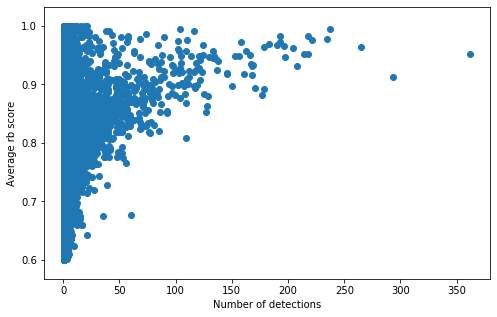

In [26]:
# Plotting the mean results
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_mean )
plt.xlabel( "Number of detections" )
plt.ylabel( "Average rb score" )
print(" Each data point is one candidate, and detections with R/B < 0.6 are neglected" )

Each data point is one candidate, and detections with R/B < 0.6 are neglected


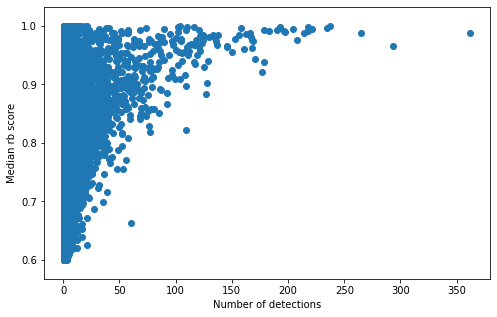

In [27]:
# Plotting the median results
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_median )
plt.xlabel( "Number of detections" )
plt.ylabel( "Median rb score" )
print( "Each data point is one candidate, and detections with R/B < 0.6 are neglected" )